In [1]:
import os
from PIL import Image
import util.image_import as ii
from glob import glob
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras import backend as K
import matplotlib.pyplot as plt
from keras.applications import mobilenet
from keras.layers import Dense, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.models import Model, Sequential
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, RMSprop, SGD
from util.plots import plot_history
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


### Subtracting mean and normalizing to save pictures

In [3]:
# Importing the images
train_pot = glob(os.path.join("../Classification/res_still/train/potato", "*.jpg"))
train_cat = glob(os.path.join("../Classification/res_still/train/catfood", "*.jpg"))
train_tab = glob(os.path.join("../Classification/res_still/train/table", "*.jpg"))
val_pot   = glob(os.path.join("../Classification/res_still/valid/potato", "*.jpg"))
val_cat   = glob(os.path.join("../Classification/res_still/valid/catfood", "*.jpg"))
val_tab   = glob(os.path.join("../Classification/res_still/valid/table", "*.jpg"))
test_pot  = glob(os.path.join("../Classification/res_still/test/potato", "*.jpg"))
test_cat  = glob(os.path.join("../Classification/res_still/test/catfood", "*.jpg"))
test_tab  = glob(os.path.join("../Classification/res_still/test/table", "*.jpg"))

X_train, y_train = ii.images_to_numpy(train_pot, train_cat, train_tab)
X_val, y_val = ii.images_to_numpy(val_pot, val_cat, val_tab)
X_test, y_test = ii.images_to_numpy(test_pot, test_cat, test_tab)

batch_size = 32
num_classes = 3

# Making datagen for training with normilization, center, and dataugmentation
train_datagen = ImageDataGenerator(
        featurewise_center=True,
        #featurewise_std_normalization=True
        rescale=1./255,
        rotation_range=10,
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range=(0.65, 1.35)
)

# Making datagen for validation and test with normilization
valid_datagen = ImageDataGenerator(
        featurewise_center=True, 
        #featurewise_std_normalization=True
        rescale=1./255
)


X_train = X_train.astype(float)
X_val = X_val.astype(float)
X_test = X_test.astype(float)

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

# Required for featurewise normalization
train_datagen.fit(X_train/255.)
valid_datagen.fit(X_train/255.)

train_generator = train_datagen.flow(X_train,
                                     y_train,
                                     batch_size=batch_size, shuffle=True)

validation_generator = valid_datagen.flow(X_val,
                                     y_val,
                                     batch_size=batch_size, shuffle=True)

test_generator = valid_datagen.flow(X_test,
                                     y_test,
                                     batch_size=50, shuffle=True)


## Optimized model

#### Trick to configure gpu memory dynamically

In [15]:
cfg = K.tf.ConfigProto() # Config to dynamically add memory
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))# set this TensorFlow session as the default session for Keras.

In [16]:
model = Sequential()
model.add(Flatten(input_shape=(224,224,3)))
# kernel_regularizer: Regularizer function applied to the kernel weights matrix (see regularizer).
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-5), # lr=0.0001
              metrics=['accuracy'])

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               38535424  
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 38,536,195
Trainable params: 38,536,195
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=384 // batch_size,
            epochs=100,
            validation_data=validation_generator,
            validation_steps=100 // batch_size)


Epoch 1/100
12/12 [==============================] - 4s 329ms/step - loss: 1.1455 - acc: 0.3796 - val_loss: 1.0340 - val_acc: 0.4688
Epoch 2/100
12/12 [==============================] - 3s 271ms/step - loss: 1.1839 - acc: 0.4137 - val_loss: 1.0619 - val_acc: 0.5521
Epoch 3/100
12/12 [==============================] - 3s 278ms/step - loss: 1.0653 - acc: 0.4740 - val_loss: 0.9608 - val_acc: 0.5208
Epoch 4/100
12/12 [==============================] - 3s 267ms/step - loss: 0.9838 - acc: 0.4815 - val_loss: 0.9356 - val_acc: 0.6146
Epoch 5/100
12/12 [==============================] - 3s 260ms/step - loss: 0.9625 - acc: 0.6178 - val_loss: 0.9393 - val_acc: 0.5833
Epoch 6/100
12/12 [==============================] - 3s 280ms/step - loss: 0.9804 - acc: 0.5889 - val_loss: 0.8518 - val_acc: 0.5833
Epoch 7/100
12/12 [==============================] - 3s 260ms/step - loss: 0.9800 - acc: 0.5784 - val_loss: 0.8450 - val_acc: 0.7500
Epoch 8/100
12/12 [==============================] - 3s 288ms/step - 

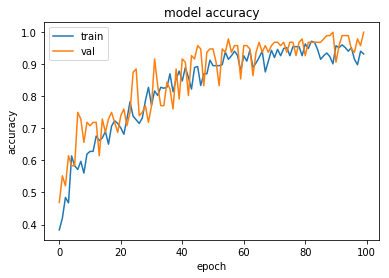

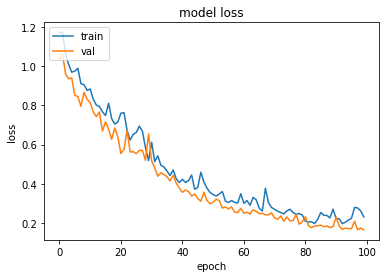

In [18]:
plot_history(history, mean_N=1)

In [ ]:
imgs, labels = next(test_generator)

#ynew = model.predict(imgs)
results[(lr, lrd, rs, hl)] = (y_train_acc, y_pred_acc)

model.evaluate(imgs,labels, batch_size=50)

In [ ]:
imgs, labels = next(validation_generator)
model.predict(imgs)
#print(imgs)


## Hyperparameter optimization

In [11]:
# Only work with tensorflow=1.8 and keras=2.1.6 because of the memory allocation

# Hyperparameters
learning_rates = [1e-4, 1e-5];
hidden_size = [64, 128, 256, 512];
history = []
result = None
results = []

for lr in learning_rates:
    for hs in hidden_size:
        # GPU memory allocation
        cfg = K.tf.ConfigProto() # Create setup file for keras tensorflow
        cfg.gpu_options.allow_growth = True # Setting setup file with dynamically adding gpu memory
        K.set_session(K.tf.Session(config=cfg)) # Setting session to use setup file
        sess = tf.Session() 
        K.set_session(sess)# set this TensorFlow session as the default session for Keras.
        
        # Defining the model:
        model = Sequential()
        model.add(Flatten(input_shape=(224,224,3)))
        model.add(Dense(hs))
        model.add(Activation('relu'))
        model.add(Dense(3))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr=lr),
                      metrics=['accuracy'])
        
        
        # Running the model:
        temp = (model.fit_generator(
            train_generator,
            steps_per_epoch=384 // batch_size,
            epochs=100,
            validation_data=validation_generator,
            validation_steps=100 // batch_size))
        
        # Saving the results
        history.append(temp)
        train_acc = temp.history['acc'].pop()
        val_acc = temp.history['val_acc'].pop()
        result = (lr, hs, train_acc, val_acc)
        results.append(result)
        K.clear_session() # Clearing the session to clear out gpu memory
        

Epoch 1/100
12/12 [==============================] - 3s 291ms/step - loss: 8.2487 - acc: 0.4032 - val_loss: 12.9281 - val_acc: 0.1979
Epoch 2/100
12/12 [==============================] - 3s 283ms/step - loss: 9.9604 - acc: 0.3714 - val_loss: 12.9281 - val_acc: 0.1979
Epoch 3/100
12/12 [==============================] - 4s 293ms/step - loss: 9.5978 - acc: 0.3901 - val_loss: 12.9281 - val_acc: 0.1979
Epoch 4/100
12/12 [==============================] - 4s 301ms/step - loss: 9.4958 - acc: 0.3875 - val_loss: 12.9281 - val_acc: 0.1979
Epoch 5/100
12/12 [==============================] - 4s 292ms/step - loss: 9.6614 - acc: 0.3901 - val_loss: 12.9281 - val_acc: 0.1979
Epoch 6/100
12/12 [==============================] - 4s 293ms/step - loss: 9.3994 - acc: 0.4133 - val_loss: 12.7602 - val_acc: 0.2083
Epoch 7/100
12/12 [==============================] - 4s 298ms/step - loss: 9.2799 - acc: 0.4186 - val_loss: 12.7606 - val_acc: 0.2083
Epoch 8/100
12/12 [==============================] - 4s 307ms/

12/12 [==============================] - 4s 317ms/step - loss: 9.0916 - acc: 0.4317 - val_loss: 9.7380 - val_acc: 0.3958
Epoch 63/100
12/12 [==============================] - 4s 362ms/step - loss: 9.9828 - acc: 0.3800 - val_loss: 9.7380 - val_acc: 0.3958
Epoch 64/100
12/12 [==============================] - 4s 333ms/step - loss: 9.5346 - acc: 0.4085 - val_loss: 9.7380 - val_acc: 0.3958
Epoch 65/100
12/12 [==============================] - 4s 312ms/step - loss: 9.1698 - acc: 0.4294 - val_loss: 9.7380 - val_acc: 0.3958
Epoch 66/100
12/12 [==============================] - 4s 309ms/step - loss: 9.4523 - acc: 0.4111 - val_loss: 9.7380 - val_acc: 0.3958
Epoch 67/100
12/12 [==============================] - 4s 312ms/step - loss: 9.7464 - acc: 0.3931 - val_loss: 9.7380 - val_acc: 0.3958
Epoch 68/100
12/12 [==============================] - 4s 305ms/step - loss: 8.9513 - acc: 0.4422 - val_loss: 9.7380 - val_acc: 0.3958
Epoch 69/100
12/12 [==============================] - 4s 320ms/step - loss:

12/12 [==============================] - 5s 416ms/step - loss: 9.2445 - acc: 0.4265 - val_loss: 9.7380 - val_acc: 0.3958
Epoch 85/100
12/12 [==============================] - 5s 413ms/step - loss: 9.6191 - acc: 0.4032 - val_loss: 9.7380 - val_acc: 0.3958
Epoch 86/100
12/12 [==============================] - 5s 415ms/step - loss: 9.2445 - acc: 0.4265 - val_loss: 9.7380 - val_acc: 0.3958
Epoch 87/100
12/12 [==============================] - 5s 410ms/step - loss: 9.2445 - acc: 0.4265 - val_loss: 9.7380 - val_acc: 0.3958
Epoch 88/100
12/12 [==============================] - 5s 422ms/step - loss: 9.6191 - acc: 0.4032 - val_loss: 9.7380 - val_acc: 0.3958
Epoch 89/100
12/12 [==============================] - 5s 440ms/step - loss: 9.9936 - acc: 0.3800 - val_loss: 9.7380 - val_acc: 0.3958
Epoch 90/100
12/12 [==============================] - 5s 427ms/step - loss: 9.6191 - acc: 0.4032 - val_loss: 9.7380 - val_acc: 0.3958
Epoch 91/100
12/12 [==============================] - 5s 418ms/step - loss:

12/12 [==============================] - 3s 266ms/step - loss: 10.4224 - acc: 0.3512 - val_loss: 9.7380 - val_acc: 0.3958
Epoch 7/100
12/12 [==============================] - 3s 282ms/step - loss: 9.9763 - acc: 0.3796 - val_loss: 9.7380 - val_acc: 0.3958
Epoch 8/100
12/12 [==============================] - 3s 273ms/step - loss: 9.7091 - acc: 0.3954 - val_loss: 10.0738 - val_acc: 0.3750
Epoch 9/100
12/12 [==============================] - 3s 270ms/step - loss: 10.2109 - acc: 0.3665 - val_loss: 12.6616 - val_acc: 0.2083
Epoch 10/100
12/12 [==============================] - 3s 278ms/step - loss: 9.6459 - acc: 0.4002 - val_loss: 13.9469 - val_acc: 0.1250
Epoch 11/100
12/12 [==============================] - 3s 286ms/step - loss: 10.3751 - acc: 0.3564 - val_loss: 11.7735 - val_acc: 0.2396
Epoch 12/100
12/12 [==============================] - 3s 287ms/step - loss: 9.1178 - acc: 0.4343 - val_loss: 13.6619 - val_acc: 0.1458
Epoch 13/100
12/12 [==============================] - 3s 289ms/step - 

12/12 [==============================] - 3s 282ms/step - loss: 9.1178 - acc: 0.4343 - val_loss: 4.5332 - val_acc: 0.7188
Epoch 68/100
12/12 [==============================] - 3s 268ms/step - loss: 9.8246 - acc: 0.3905 - val_loss: 4.5332 - val_acc: 0.7188
Epoch 69/100
12/12 [==============================] - 3s 251ms/step - loss: 9.3178 - acc: 0.4219 - val_loss: 4.5332 - val_acc: 0.7188
Epoch 70/100
12/12 [==============================] - 3s 279ms/step - loss: 9.7871 - acc: 0.3905 - val_loss: 4.5332 - val_acc: 0.7188
Epoch 71/100
12/12 [==============================] - 3s 277ms/step - loss: 9.8302 - acc: 0.3901 - val_loss: 4.5332 - val_acc: 0.7188
Epoch 72/100
12/12 [==============================] - 3s 272ms/step - loss: 9.7928 - acc: 0.3901 - val_loss: 4.8690 - val_acc: 0.6979
Epoch 73/100
12/12 [==============================] - 3s 275ms/step - loss: 9.4368 - acc: 0.4137 - val_loss: 4.7011 - val_acc: 0.7083
Epoch 74/100
12/12 [==============================] - 3s 253ms/step - loss:

12/12 [==============================] - 3s 261ms/step - loss: 0.1148 - acc: 0.9686 - val_loss: 0.1311 - val_acc: 0.9583
Epoch 90/100
12/12 [==============================] - 3s 262ms/step - loss: 0.1063 - acc: 0.9659 - val_loss: 0.1305 - val_acc: 0.9688
Epoch 91/100
12/12 [==============================] - 3s 257ms/step - loss: 0.1153 - acc: 0.9764 - val_loss: 0.1284 - val_acc: 0.9375
Epoch 92/100
12/12 [==============================] - 3s 258ms/step - loss: 0.1582 - acc: 0.9476 - val_loss: 0.1245 - val_acc: 0.9688
Epoch 93/100
12/12 [==============================] - 3s 259ms/step - loss: 0.1449 - acc: 0.9555 - val_loss: 0.1647 - val_acc: 0.9167
Epoch 94/100
12/12 [==============================] - 3s 268ms/step - loss: 0.1435 - acc: 0.9502 - val_loss: 0.1185 - val_acc: 0.9688
Epoch 95/100
12/12 [==============================] - 3s 254ms/step - loss: 0.1526 - acc: 0.9555 - val_loss: 0.1136 - val_acc: 0.9583
Epoch 96/100
12/12 [==============================] - 3s 253ms/step - loss:

12/12 [==============================] - 3s 264ms/step - loss: 1.0770 - acc: 0.5680 - val_loss: 0.6709 - val_acc: 0.6979
Epoch 12/100
12/12 [==============================] - 3s 257ms/step - loss: 0.8379 - acc: 0.6646 - val_loss: 0.8747 - val_acc: 0.5938
Epoch 13/100
12/12 [==============================] - 3s 276ms/step - loss: 0.8179 - acc: 0.6593 - val_loss: 0.6131 - val_acc: 0.7708
Epoch 14/100
12/12 [==============================] - 3s 265ms/step - loss: 0.9918 - acc: 0.6544 - val_loss: 0.7346 - val_acc: 0.7188
Epoch 15/100
12/12 [==============================] - 3s 253ms/step - loss: 0.7386 - acc: 0.7196 - val_loss: 0.5270 - val_acc: 0.7188
Epoch 16/100
12/12 [==============================] - 3s 273ms/step - loss: 0.8360 - acc: 0.6731 - val_loss: 0.5209 - val_acc: 0.7708
Epoch 17/100
12/12 [==============================] - 3s 260ms/step - loss: 0.6864 - acc: 0.6990 - val_loss: 0.5021 - val_acc: 0.7292
Epoch 18/100
12/12 [==============================] - 3s 262ms/step - loss:

12/12 [==============================] - 3s 265ms/step - loss: 0.9269 - acc: 0.7773 - val_loss: 0.3997 - val_acc: 0.8646
Epoch 34/100
12/12 [==============================] - 3s 265ms/step - loss: 0.9402 - acc: 0.7226 - val_loss: 0.4102 - val_acc: 0.7500
Epoch 35/100
12/12 [==============================] - 3s 273ms/step - loss: 0.6347 - acc: 0.7773 - val_loss: 0.4020 - val_acc: 0.7917
Epoch 36/100
12/12 [==============================] - 3s 258ms/step - loss: 0.5005 - acc: 0.8061 - val_loss: 0.3111 - val_acc: 0.9167
Epoch 37/100
12/12 [==============================] - 3s 279ms/step - loss: 0.6064 - acc: 0.7802 - val_loss: 0.3118 - val_acc: 0.8958
Epoch 38/100
12/12 [==============================] - 3s 273ms/step - loss: 0.6653 - acc: 0.7851 - val_loss: 0.3234 - val_acc: 0.8229
Epoch 39/100
12/12 [==============================] - 3s 271ms/step - loss: 0.4980 - acc: 0.8270 - val_loss: 0.3176 - val_acc: 0.9167
Epoch 40/100
12/12 [==============================] - 3s 261ms/step - loss:

12/12 [==============================] - 3s 251ms/step - loss: 0.4455 - acc: 0.8510 - val_loss: 0.4510 - val_acc: 0.8125
Epoch 56/100
12/12 [==============================] - 3s 270ms/step - loss: 0.4441 - acc: 0.8559 - val_loss: 0.4233 - val_acc: 0.7500
Epoch 57/100
12/12 [==============================] - 3s 256ms/step - loss: 0.4992 - acc: 0.7959 - val_loss: 0.4177 - val_acc: 0.7604
Epoch 58/100
12/12 [==============================] - 3s 255ms/step - loss: 0.4870 - acc: 0.8379 - val_loss: 0.4707 - val_acc: 0.8750
Epoch 59/100
12/12 [==============================] - 3s 268ms/step - loss: 0.4562 - acc: 0.8716 - val_loss: 0.4055 - val_acc: 0.7396
Epoch 60/100
12/12 [==============================] - 3s 259ms/step - loss: 0.4458 - acc: 0.8222 - val_loss: 0.4168 - val_acc: 0.7604
Epoch 61/100
12/12 [==============================] - 3s 250ms/step - loss: 0.4542 - acc: 0.8510 - val_loss: 0.4064 - val_acc: 0.8750
Epoch 62/100
12/12 [==============================] - 3s 259ms/step - loss:

12/12 [==============================] - 3s 256ms/step - loss: 0.2993 - acc: 0.9476 - val_loss: 0.2612 - val_acc: 0.9271
Epoch 78/100
12/12 [==============================] - 3s 267ms/step - loss: 0.2995 - acc: 0.9528 - val_loss: 0.2669 - val_acc: 0.9375
Epoch 79/100
12/12 [==============================] - 3s 266ms/step - loss: 0.2798 - acc: 0.9397 - val_loss: 0.2324 - val_acc: 0.9375
Epoch 80/100
12/12 [==============================] - 3s 244ms/step - loss: 0.3610 - acc: 0.8978 - val_loss: 0.2587 - val_acc: 0.9167
Epoch 81/100
12/12 [==============================] - 3s 268ms/step - loss: 0.3427 - acc: 0.8847 - val_loss: 0.2547 - val_acc: 0.9167
Epoch 82/100
12/12 [==============================] - 3s 249ms/step - loss: 0.3347 - acc: 0.9004 - val_loss: 0.2545 - val_acc: 0.9271
Epoch 83/100
12/12 [==============================] - 3s 263ms/step - loss: 0.2669 - acc: 0.9319 - val_loss: 0.2199 - val_acc: 0.9479
Epoch 84/100
12/12 [==============================] - 3s 256ms/step - loss:

12/12 [==============================] - 4s 317ms/step - loss: 0.1888 - acc: 0.9633 - val_loss: 0.1811 - val_acc: 0.9896
Epoch 100/100
12/12 [==============================] - 4s 326ms/step - loss: 0.1803 - acc: 0.9790 - val_loss: 0.1830 - val_acc: 0.9688
Epoch 1/100
12/12 [==============================] - 4s 359ms/step - loss: 1.2068 - acc: 0.4399 - val_loss: 1.0521 - val_acc: 0.3542
Epoch 2/100
12/12 [==============================] - 4s 348ms/step - loss: 1.0916 - acc: 0.4504 - val_loss: 0.9757 - val_acc: 0.5625
Epoch 3/100
12/12 [==============================] - 4s 332ms/step - loss: 1.0828 - acc: 0.3980 - val_loss: 0.9460 - val_acc: 0.3542
Epoch 4/100
12/12 [==============================] - 4s 324ms/step - loss: 1.0615 - acc: 0.5080 - val_loss: 0.8791 - val_acc: 0.6979
Epoch 5/100
12/12 [==============================] - 4s 323ms/step - loss: 1.1150 - acc: 0.4871 - val_loss: 0.7958 - val_acc: 0.7188
Epoch 6/100
12/12 [==============================] - 4s 325ms/step - loss: 0.96

______________________________________________________________________
lr 1.000000e-03 hs 64 train accuracy: 0.388732 val accuracy: 0.395833


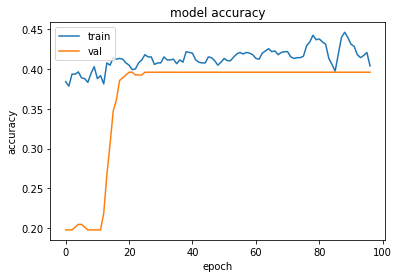

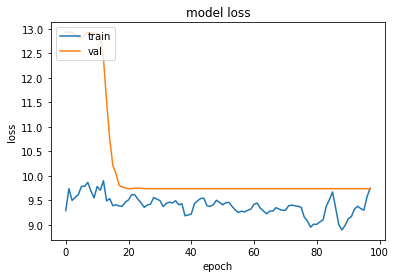

______________________________________________________________________
lr 1.000000e-03 hs 128 train accuracy: 0.408451 val accuracy: 0.395833


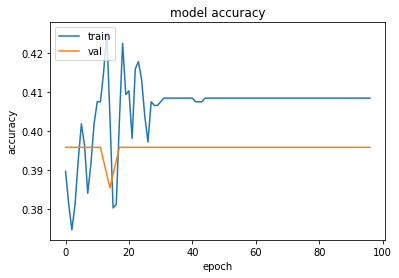

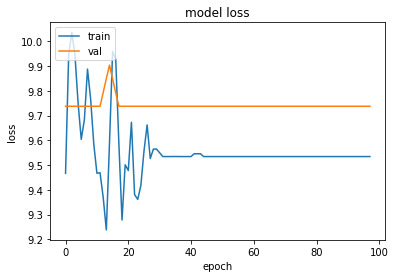

______________________________________________________________________
lr 1.000000e-03 hs 256 train accuracy: 0.467606 val accuracy: 0.572917


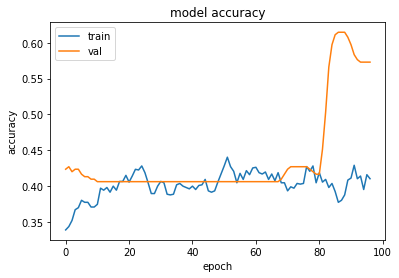

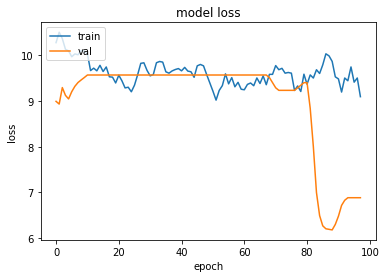

______________________________________________________________________
lr 1.000000e-03 hs 512 train accuracy: 0.414085 val accuracy: 0.614583


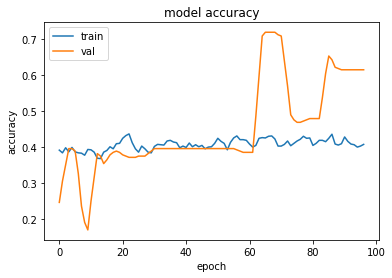

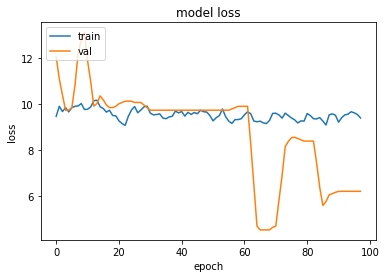

______________________________________________________________________
lr 1.000000e-04 hs 64 train accuracy: 0.969014 val accuracy: 0.968750


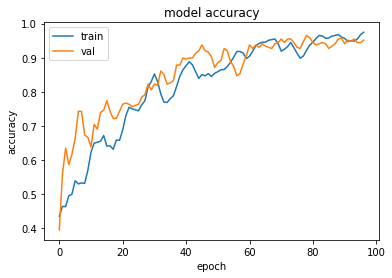

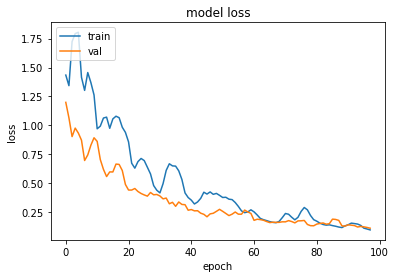

______________________________________________________________________
lr 1.000000e-04 hs 128 train accuracy: 0.954930 val accuracy: 0.958333


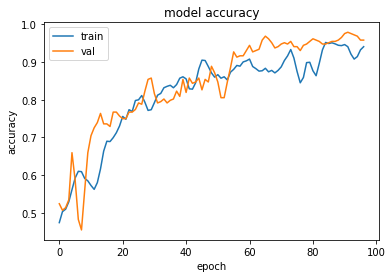

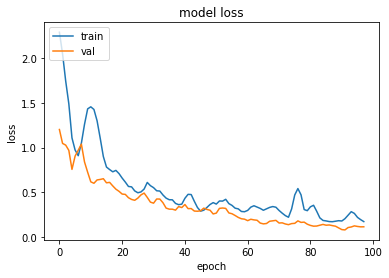

______________________________________________________________________
lr 1.000000e-04 hs 256 train accuracy: 0.814085 val accuracy: 0.968750


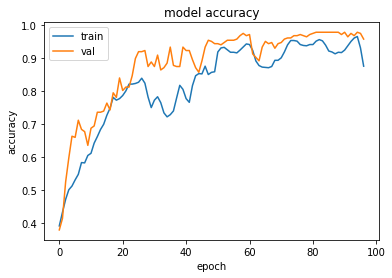

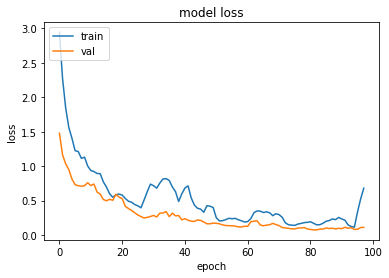

______________________________________________________________________
lr 1.000000e-04 hs 512 train accuracy: 0.983099 val accuracy: 0.968750


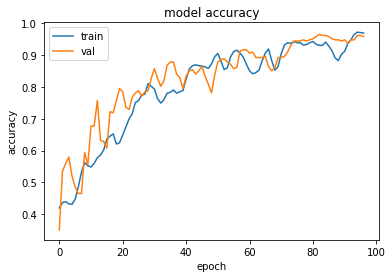

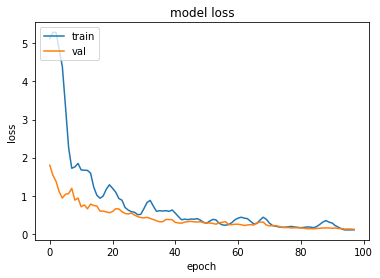

______________________________________________________________________
lr 1.000000e-05 hs 64 train accuracy: 0.904225 val accuracy: 0.937500


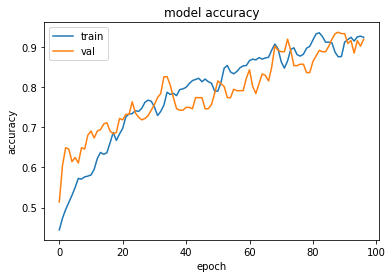

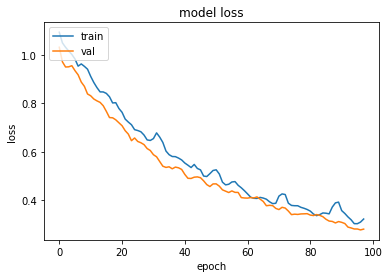

______________________________________________________________________
lr 1.000000e-05 hs 128 train accuracy: 0.907042 val accuracy: 0.958333


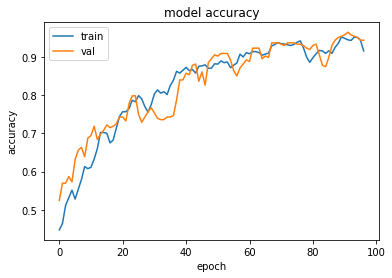

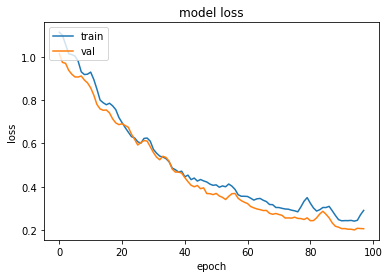

______________________________________________________________________
lr 1.000000e-05 hs 256 train accuracy: 0.977465 val accuracy: 0.968750


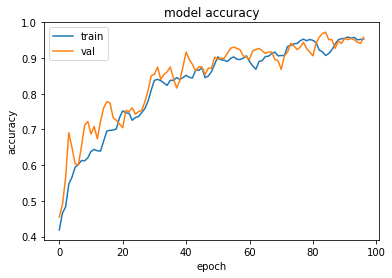

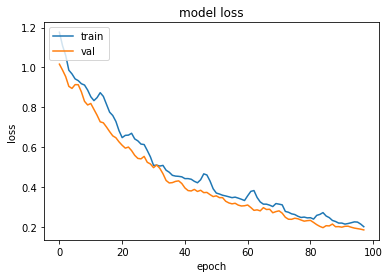

______________________________________________________________________
lr 1.000000e-05 hs 512 train accuracy: 0.946479 val accuracy: 0.958333


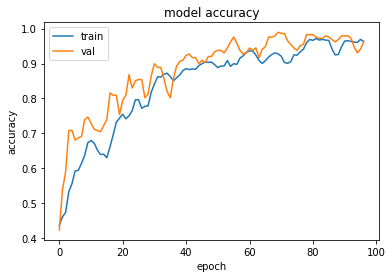

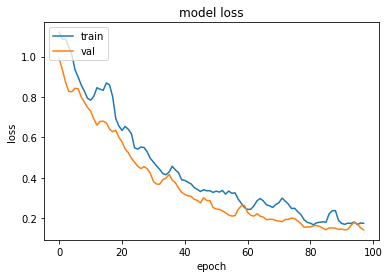

In [12]:
for index, h in enumerate(history):
    print("______________________________________________________________________")
    print('lr %e hs %i train accuracy: %f val accuracy: %f' % results[index])         
    plot_history(h, mean_N=3)


In [13]:
for r in results:
    print('lr %e hs %i train accuracy: %f val accuracy: %f' % r) 

lr 1.000000e-03 hs 64 train accuracy: 0.388732 val accuracy: 0.395833
lr 1.000000e-03 hs 128 train accuracy: 0.408451 val accuracy: 0.395833
lr 1.000000e-03 hs 256 train accuracy: 0.467606 val accuracy: 0.572917
lr 1.000000e-03 hs 512 train accuracy: 0.414085 val accuracy: 0.614583
lr 1.000000e-04 hs 64 train accuracy: 0.969014 val accuracy: 0.968750
lr 1.000000e-04 hs 128 train accuracy: 0.954930 val accuracy: 0.958333
lr 1.000000e-04 hs 256 train accuracy: 0.814085 val accuracy: 0.968750
lr 1.000000e-04 hs 512 train accuracy: 0.983099 val accuracy: 0.968750
lr 1.000000e-05 hs 64 train accuracy: 0.904225 val accuracy: 0.937500
lr 1.000000e-05 hs 128 train accuracy: 0.907042 val accuracy: 0.958333
lr 1.000000e-05 hs 256 train accuracy: 0.977465 val accuracy: 0.968750
lr 1.000000e-05 hs 512 train accuracy: 0.946479 val accuracy: 0.958333


**Based on graph and results above of the training and validation accuracy the following hyperparameters is found to be the optimal:** 
```
Learning rate       = 1e-4
Hidden size         = 500
```
**Which gives the following results for 100 epoch for 1 training run:**
```
Train accuracy      = 0.983099
Validation accuracy = 0.968750
```